# Anomalous Financial Transaction Detection

본 대회의 과제는 금융 거래 데이터에서 **이상 거래를 탐지하는 기능**을 개선하고 활용도를 높이는 분류 AI모델을 개발하는 것입니다. 

특히, 클래스 불균형 문제를 해결하기 위해 오픈소스 생성형 AI 모델을 활용하여 부족한 클래스의 데이터를 보완하고, 이를 통해 분류 모델의 성능을 향상시키는 것이 핵심 목표입니다. 

이러한 접근을 통해 금융보안에 특화된 데이터 분석 및 활용 역량을 강화하여 전문 인력을 양성하고, 금융권의 AI 활용 어려움에 따른 해결 방안을 함께 모색하며 금융 산업의 AI 활용 활성화를 지원하는 것을 목표로 합니다.

# Import Library

In [43]:
# 제출 파일 생성 관련
import os
import zipfile

# 데이터 처리 및 분석
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm

# 머신러닝 전처리
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# 머신러닝 모델
import xgboost as xgb

# 합성 데이터 생성
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

# To ignore all warnings
import warnings
warnings.filterwarnings('ignore')

# pycaret AutoML 사용
import pycaret
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment


In [44]:
pycaret.__version__

'3.3.2'

# 생성 🏭

# Load Data

In [45]:
train_all = pd.read_csv("/workspace/Dataset/FSI/clip_downloads/FSI/train_features.csv")
test_all = pd.read_csv("/workspace/Dataset/FSI/clip_downloads/FSI/test_features.csv")

In [46]:
all_synthetic_data = pd.read_csv("/workspace/Dataset/FSI/clip_downloads/FSI/generated_data_features.csv")

## 원본 데이터와 concat

In [47]:
origin_train = train_all.drop(columns="ID")
all_synthetic_data = all_synthetic_data.drop(columns="ID")
train_total = pd.concat([origin_train, all_synthetic_data], ignore_index=True)
train_total.shape

(250000, 257)

In [48]:
train_total.head()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_247,Feature_248,Feature_249,Feature_250,Feature_251,Feature_252,Feature_253,Feature_254,Feature_255,Fraud_Type
0,0.880163,-1.119654,-1.288096,-1.374387,0.616114,0.527632,-0.598587,0.601537,1.324492,1.096167,...,-1.058133,1.355208,-1.785255,1.475678,-0.136004,-1.324057,-0.334166,0.770605,0.711004,12.0
1,0.900374,-1.119269,-1.350800,-1.363732,0.645792,0.504497,-0.533358,0.610816,1.312548,1.082016,...,-0.993603,1.396403,-1.887138,1.484958,-0.120737,-1.272975,-0.418074,0.751052,0.684775,12.0
2,0.869114,-1.126157,-1.294111,-1.388630,0.629380,0.501532,-0.557485,0.596676,1.332982,1.103749,...,-1.016553,1.357152,-1.832411,1.478184,-0.158911,-1.305501,-0.409247,0.765062,0.687483,12.0
3,0.878418,-1.125741,-1.310068,-1.376499,0.635101,0.496822,-0.559677,0.611012,1.325877,1.097270,...,-1.016051,1.372284,-1.853848,1.480517,-0.148698,-1.292589,-0.425839,0.758834,0.695257,12.0
4,1.217422,-1.414048,-0.178742,-0.854678,0.289796,0.225006,-0.762616,-0.670094,0.705489,1.033402,...,-0.072828,1.090991,-1.761935,0.367776,-0.313025,-0.949463,-1.672828,0.685014,0.799470,12.0


In [49]:
# 폴더 생성 및 작업 디렉토리 변경
os.makedirs('/workspace/Dataset/FSI/clip_downloads/submission', exist_ok=True)
os.chdir("/workspace/Dataset/FSI/clip_downloads/submission")

# Data Preprocessing : pycaret setup / pycaret exp(init class)

In [50]:
exp = ClassificationExperiment()
type(exp)

pycaret.classification.oop.ClassificationExperiment

In [51]:
exp.setup(train_total, target = 'Fraud_Type', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Fraud_Type
2,Target type,Multiclass
3,Original data shape,"(250000, 257)"
4,Transformed data shape,"(250000, 257)"
5,Transformed train set shape,"(175000, 257)"
6,Transformed test set shape,"(75000, 257)"
7,Numeric features,256
8,Preprocess,True
9,Imputation type,simple


# Compare Models : 모델 선정(autoML)

In [52]:
print(exp.models().index)


Index(['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf',
       'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'dummy'],
      dtype='object', name='ID')


In [53]:
for id in exp.models().index[5:]:
    if(id is 'rbfsvm'):
        continue
    exp.compare_models(include = [id])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5895,0.0000,0.5895,0.5530,0.5543,0.3569,0.3695,15.3900


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.5361,0.7172,0.5361,0.5201,0.5248,0.3233,0.3248,6.8540


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.3258,0.6426,0.3258,0.5019,0.3058,0.2654,0.3155,0.5090


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.4455,0.6049,0.4455,0.4508,0.4480,0.2328,0.2329,8.8720


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.5729,0.0000,0.5729,0.5083,0.5169,0.3089,0.3296,2.8400


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:50:41
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,SVM - Radial Kernel


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
best = exp.compare_models(include = ['xgboost']) #compare models by OOP method(nothing different from compare_models() function)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.5909,0.7995,0.5909,0.5765,0.5560,0.3508,0.3664,21.8410


In [13]:
# save pipeline
exp.save_model(best, '/workspace/Dacon_FSI/automl/pycaret')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Feature_0', 'Feature_1',
                                              'Feature_2', 'Feature_3',
                                              'Feature_4', 'Feature_5',
                                              'Feature_6', 'Feature_7',
                                              'Feature_8', 'Feature_9',
                                              'Feature_10', 'Feature_11',
                                              'Feature_12', 'Feature_13',
                                              'Feature_14', 'Feature_15',
                                              'Feature_16', 'Feature_17',
                                              'Feature_18', 'Featu...
                                importance_type=None,
                                interaction_constraints=None, learning_rate=None,
        

# Feature Imortance : Feature 중요도 확인(autoML)

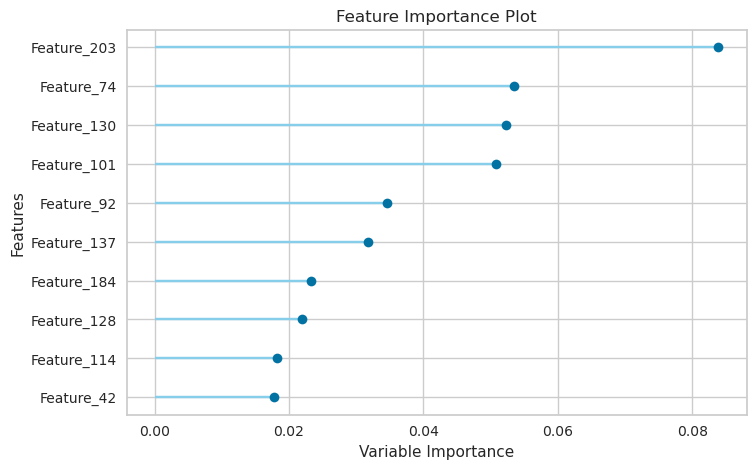

In [15]:
# plot feature importance
exp.plot_model(best, plot = 'feature') #KNN등은 안될수도잇음

# Prediction

In [16]:
# predict on test set
holdout_pred = exp.predict_model(best, data=test_all)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.0172,0,0,0,0,0.0000,0.0000


In [17]:
holdout_pred

,ID,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_249,Feature_250,Feature_251,Feature_252,Feature_253,Feature_254,Feature_255,Fraud_Type,prediction_label,prediction_score
0,0.0,0.811023,-0.884546,-1.577283,-1.299030,0.632926,0.571585,-0.327909,0.475349,1.155972,...,-2.105103,1.452120,-0.009145,-1.186005,-0.440749,0.715322,0.498263,0.0,12,0.5504
1,1.0,0.888021,-1.123688,-1.326016,-1.367326,0.639414,0.498377,-0.550863,0.613569,1.318789,...,-1.869777,1.483557,-0.139447,-1.282944,-0.430462,0.754942,0.691431,0.0,8,0.4713
2,2.0,1.313471,-1.439565,-1.062526,-1.363477,0.571448,0.384888,-0.757616,0.035276,1.262327,...,-1.895217,1.005348,-0.225797,-1.341675,-0.667736,0.815928,0.935092,0.0,12,0.5540
3,3.0,0.873229,-1.124686,-1.302504,-1.374289,0.631282,0.500220,-0.561970,0.605419,1.325131,...,-1.847030,1.481797,-0.154946,-1.295815,-0.430337,0.760087,0.688607,0.0,12,0.8703
4,4.0,0.946826,-1.074133,-1.323102,-1.346335,0.638889,0.468431,-0.583506,0.655180,1.330531,...,-1.916018,1.519735,-0.076931,-1.276022,-0.434645,0.749384,0.724769,0.0,12,0.6809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,119995.0,1.623411,0.018297,-0.943115,-0.919865,0.613972,-0.072547,-0.772227,0.636131,0.719791,...,0.479314,-0.210427,-0.175270,-0.495574,1.773592,0.515972,0.992709,0.0,12,0.5025
119996,119996.0,0.870096,-1.126793,-1.299274,-1.383808,0.631674,0.500794,-0.557830,0.599159,1.329966,...,-1.840598,1.478379,-0.159223,-1.300883,-0.417705,0.762833,0.687601,0.0,12,0.6157
119997,119997.0,0.868297,-1.144031,-1.300323,-1.420733,0.621814,0.511076,-0.530012,0.582274,1.344216,...,-1.803948,1.476241,-0.148063,-1.315493,-0.387314,0.772619,0.679863,0.0,12,0.7509
119998,119998.0,1.741475,-0.555028,-1.381276,-1.354762,0.731899,0.196707,-0.782255,0.666096,1.151647,...,-0.335599,0.659950,-0.109424,-1.008523,1.437853,0.660298,1.105610,0.0,12,0.5444


# Submission

In [18]:
# 분류 예측 결과 제출 데이터프레임(DataFrame)
# 분류 예측 결과 데이터프레임 파일명을 반드시 clf_submission.csv 로 지정해야합니다.
clf_submission = pd.read_csv("/workspace/Dataset/FSI/sample_submission.csv")
clf_submission["Fraud_Type"] = holdout_pred.prediction_label
clf_submission.head()

,ID,Fraud_Type
0,TEST_000000,12
1,TEST_000001,8
2,TEST_000002,12
3,TEST_000003,12
4,TEST_000004,12


In [26]:
mapping = {
    0: 'a',
    1: 'b',
    2: 'c',
    3: 'd',
    4: 'e',
    5: 'f',
    6: 'g',
    7: 'h',
    8: 'i',
    9: 'j',
    10: 'k',
    11: 'l',
    12: 'm'
}

# Apply the mapping to get the original labels
clf_submission['Fraud_Type'] = clf_submission['Fraud_Type'].map(mapping)

# Print the results
print(clf_submission[['ID', 'Fraud_Type']])

                 ID Fraud_Type
0       TEST_000000          m
1       TEST_000001          i
2       TEST_000002          m
3       TEST_000003          m
4       TEST_000004          m
...             ...        ...
119995  TEST_119995          m
119996  TEST_119996          m
119997  TEST_119997          m
119998  TEST_119998          m
119999  TEST_119999          m

[120000 rows x 2 columns]


In [27]:
# 합성 데이터 생성 결과 제출 데이터프레임(DataFrame)
# 합성 데이터 생성 결과 데이터프레임 파일명을 반드시 syn_submission.csv 로 지정해야합니다.
all_synthetic_data.head()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_247,Feature_248,Feature_249,Feature_250,Feature_251,Feature_252,Feature_253,Feature_254,Feature_255,Fraud_Type
0,0.885936,-1.122598,-1.314229,-1.367108,0.636343,0.494710,-0.562223,0.612917,1.319658,1.090834,...,-1.017465,1.376495,-1.870669,1.480747,-0.147397,-1.287513,-0.439808,0.755857,0.698420,12.0
1,0.880793,-1.124869,-1.307368,-1.371465,0.636384,0.496053,-0.566216,0.605696,1.323565,1.098862,...,-1.021952,1.372676,-1.863031,1.475643,-0.155939,-1.293964,-0.427294,0.758540,0.699163,12.0
2,-0.377666,0.339209,0.398247,-1.409007,-1.089655,1.679317,0.855296,0.394174,0.803502,0.974490,...,-0.277106,-0.373129,0.285689,1.221917,1.118260,-1.194958,1.369991,0.624189,-0.188979,12.0
3,0.879569,-1.125141,-1.307529,-1.372353,0.635688,0.496774,-0.564435,0.606254,1.323713,1.098156,...,-1.020210,1.371682,-1.860295,1.477029,-0.154930,-1.293683,-0.428403,0.758641,0.696971,12.0
4,0.748027,-1.183629,-1.236481,-1.185666,0.453873,0.863147,-0.491778,0.509654,1.200555,0.866810,...,-1.098041,1.094831,-1.407425,1.595232,-0.024976,-1.390815,0.035027,0.800254,0.443231,12.0


In [28]:
'''
(*) 저장 시 각 파일명을 반드시 확인해주세요.
    1. 분류 예측 결과 데이터프레임 파일명 = clf_submission.csv
    2. 합성 데이터 생성 결과 데이터프레임 파일명 = syn_submission.csv

(*) 제출 파일(zip) 내에 두 개의 데이터프레임이 각각 위의 파일명으로 반드시 존재해야합니다.
(*) 파일명을 일치시키지 않으면 채점이 불가능합니다.
'''

os.makedirs('/workspace/Dacon_FSI/automl/pycaret/submission', exist_ok=True)
os.chdir("/workspace/Dacon_FSI/automl/pycaret/submission")

# CSV 파일로 저장
clf_submission.to_csv('/workspace/Dacon_FSI/automl/pycaret/submission/clf_submission.csv', encoding='UTF-8-sig', index=False)
all_synthetic_data.to_csv('/workspace/Dacon_FSI/automl/pycaret/submission/syn_submission.csv', encoding='UTF-8-sig', index=False)



# ZIP 파일 생성 및 CSV 파일 추가
with zipfile.ZipFile("/workspace/Dacon_FSI/automl/pycaret/submission/baseline_submission.zip", 'w') as submission:
    submission.write('clf_submission.csv')
    submission.write('syn_submission.csv')
    
print('Done.')

Done.
